In [4]:
from rbergomi import rBergomi
from data import param_generator
from data import rBergomi_pricer
import numpy as np 
import pandas as pd 
def generate_rBergomi_surface(param_generator, S0=1.0):
    params = param_generator()
    H, eta, rho, v0 = params['H'], params['eta'], params['rho'], params['v0']

    moneyness_grid = np.linspace(0.6, 1.4, 8)
    maturity_grid = np.linspace(0.1, 2.0, 11)
    iv_grid = np.zeros((len(moneyness_grid), len(maturity_grid)))

    for i, moneyness in enumerate(moneyness_grid):
        K = moneyness * S0
        for j, T in enumerate(maturity_grid):
            _, iv = rBergomi_pricer(H, eta, rho, v0, T, K, S0)
            iv_grid[i, j] = iv

    sample = {
        'H': H,
        'eta': eta,
        'rho': rho,
        'v0': v0,
        'iv_grid': iv_grid
    }
    return sample

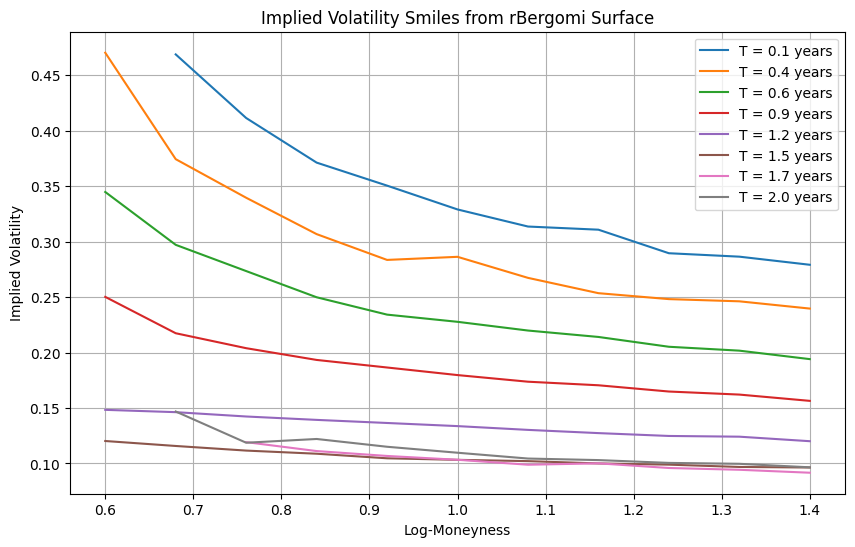

In [27]:
import numpy as np
import matplotlib.pyplot as plt
sample = generate_rBergomi_surface(param_generator)
# Define the same grids used for generation
moneyness_grid = np.linspace(0.6, 1.4, 11)
maturity_grid = np.linspace(0.1, 2.0, 8)

# Plot the smile for each maturity
plt.figure(figsize=(10, 6))

for idx, T in enumerate(maturity_grid):
    ivs = sample['iv_grid'][idx,: ]  # For fixed maturity, vary log-moneyness
    plt.plot(moneyness_grid, ivs, label=f"T = {T:.1f} years")

plt.xlabel('Log-Moneyness')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility Smiles from rBergomi Surface')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from rbergomi import rBergomi
from data import param_generator
from py_vollib.black_scholes.implied_volatility import implied_volatility

# Grid settings
moneyness_grid = np.linspace(-0.3, 0.3, 8)
maturity_grid = np.linspace(0.1, 2.0, 11)
S0 = 1.0
N_samples = 34000  # Number of surfaces to generate

all_data = []

for _ in range(N_samples):
    params = param_generator()
    H, eta, rho, v0 = params['H'], params['eta'], params['rho'], params['v0']
    
    iv_surface = []
    for maturity in maturity_grid:
        for log_moneyness in moneyness_grid:
            K = S0 * np.exp(log_moneyness)
            _, iv = rBergomi_pricer(H, eta, rho, v0, maturity, K, S0)
            iv_surface.append(iv)
    
    # Save the flattened surface + labels
    all_data.append(iv_surface + [H, eta, rho, v0])

# Define column names
surface_columns = [f"IV_{i}" for i in range(len(moneyness_grid) * len(maturity_grid))]
param_columns = ["H", "eta", "rho", "v0"]
columns = surface_columns + param_columns

# Save to CSV
df = pd.DataFrame(all_data, columns=columns)
df.to_csv("rBergomi_dataset.csv", index=False)

print(f"Saved {N_samples} rBergomi surfaces to 'rBergomi_dataset.csv'")

Random parameters: H=0.0705, eta=2.2903, rho=-0.7815, v0=0.1493

Implied Volatility Surface:
             -0.30     -0.24     -0.18     -0.12     -0.06      0.00  \
0.100000  0.569808  0.521876  0.483243  0.427455  0.380111  0.330047   
0.371429  0.455617  0.431129  0.399973  0.364508  0.346943  0.318927   
0.642857  0.414404  0.402176  0.371496  0.356368  0.334091  0.309227   
0.914286  0.389981  0.381323  0.357305  0.341205  0.320937  0.304566   
1.185714  0.378965  0.361217  0.350143  0.333746  0.312049  0.301167   
1.457143  0.366695  0.360521  0.339730  0.327480  0.306324  0.296811   
1.728571  0.357008  0.345059  0.336239  0.317641  0.307596  0.298863   
2.000000  0.350975  0.338594  0.329967  0.314296  0.304432  0.289592   

              0.06      0.12      0.18      0.24      0.30  
0.100000  0.290590  0.285117  0.301949  0.330138  0.359714  
0.371429  0.295165  0.278286  0.275613  0.269899  0.279056  
0.642857  0.293119  0.274034  0.270268  0.264136  0.267720  
0.914286  0.28

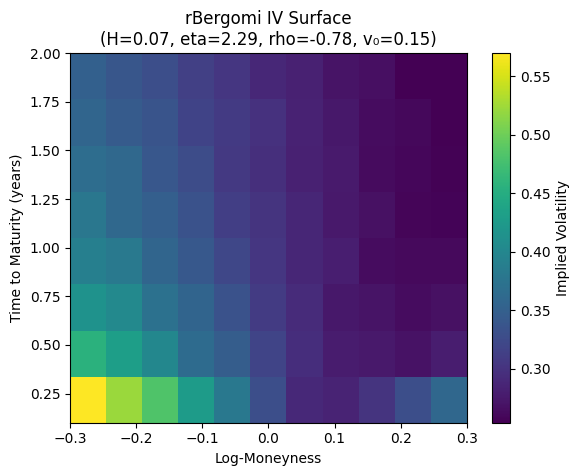

In [30]:
import numpy as np
import pandas as pd
from rbergomi import rBergomi
from data import param_generator
from py_vollib.black_scholes.implied_volatility import implied_volatility

# Step 1: Generate random parameters
params = param_generator()
H, eta, rho, v0 = params['H'], params['eta'], params['rho'], params['v0']
print(f"Random parameters: H={H:.4f}, eta={eta:.4f}, rho={rho:.4f}, v0={v0:.4f}")

# Step 2: Define grids
log_moneyness_grid = np.linspace(-0.3, 0.3, 11)
maturity_grid = np.linspace(0.1, 2.0, 8)
S0 = 1.0

# Step 3: Iterate through grid and compute implied volatilities
ivs = []

for T in maturity_grid:
    for log_moneyness in log_moneyness_grid:
        K = S0 * np.exp(log_moneyness)
        _, iv = rBergomi_pricer(H, eta, rho, v0, T, K, S0)
        if np.isnan(iv):
            iv = -1.0  # Replace NaNs with placeholder value
        ivs.append(iv)

# Step 4: Create the surface as a DataFrame (optional)
iv_surface = pd.DataFrame(
    np.array(ivs).reshape(len(maturity_grid), len(log_moneyness_grid)),
    index=maturity_grid,
    columns=log_moneyness_grid
)

# Step 5: Display the surface
print("\nImplied Volatility Surface:")
print(iv_surface)

# Step 6: Save to CSV (optional)
iv_surface.to_csv("single_rbergomi_surface.csv")

# Step 7: Plot the surface as a heatmap
import matplotlib.pyplot as plt
plt.imshow(iv_surface, origin='lower', aspect='auto', cmap='viridis',
           extent=[log_moneyness_grid[0], log_moneyness_grid[-1], maturity_grid[0], maturity_grid[-1]])
plt.colorbar(label='Implied Volatility')
plt.xlabel('Log-Moneyness')
plt.ylabel('Time to Maturity (years)')
plt.title(f"rBergomi IV Surface\n(H={H:.2f}, eta={eta:.2f}, rho={rho:.2f}, v₀={v0:.2f})")
plt.show()

In [ ]:
import numpy as np
from tqdm import tqdm
from data import param_generator
from rbergomi import rBergomi
from py_vollib.black_scholes.implied_volatility import implied_volatility

# Grids
log_moneyness_grid = np.linspace(-0.4, 0.4, 11)
maturity_grid = np.array([0.1, 0.2, 0.3, 0.6, 1.0, 1.5, 2.0, 3.0])
S0 = 1.0
n_samples = 40000

data = []

for _ in tqdm(range(n_samples)):
    params = param_generator()
    H, eta, rho, v0 = params['H'], params['eta'], params['rho'], params['v0']

    iv_surface = []
    for T in maturity_grid:
        for log_moneyness in log_moneyness_grid:
            K = S0 * np.exp(log_moneyness)
            _, iv = rBergomi_pricer(H, eta, rho, v0, T, K, S0)
            if np.isnan(iv):
                iv = -1.0  # Optional placeholder for invalid IVs
            iv_surface.append(iv)

    row = [H, eta, rho, v0] + iv_surface
    data.append(row)

# Column names
columns = ['H', 'eta', 'rho', 'v0'] + [
    f"IV_T{T:.2f}_k{log_moneyness:.2f}"
    for T in maturity_grid
    for log_moneyness in log_moneyness_grid 
]

# Save CSV
df = pd.DataFrame(data, columns=columns)
df.to_csv("rbergomi_custom_dataset.csv", index=False)

print("✅ Dataset saved as 'rbergomi_custom_dataset.csv'")

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from data import param_generator, rBergomi_pricer
from rbergomi import rBergomi
from py_vollib.black_scholes.implied_volatility import implied_volatility

# Grids
log_moneyness_grid = np.linspace(-0.4, 0.4, 11)
maturity_grid = np.array([0.1, 0.2, 0.3, 0.6, 1.0, 1.5, 2.0, 3.0])
S0 = 1.0
n_samples = 40000  # Keep small first to test!

data = []

for _ in tqdm(range(n_samples)):
    params = param_generator()
    H, eta, rho, v0 = params['H'], params['eta'], params['rho'], params['v0']

    iv_surface = []
    for T in maturity_grid:
        for log_moneyness in log_moneyness_grid:
            K = S0 * np.exp(log_moneyness)
            _, iv = rBergomi_pricer(H, eta, rho, v0, T, K, S0, )
            iv_surface.append(iv if not np.isnan(iv) else -1.0)

    row = [H, eta, rho, v0] + iv_surface
    data.append(row)

# Column names
columns = ['H', 'eta', 'rho', 'v0'] + [
    f"IV_T{T:.2f}_k{log_moneyness:.2f}"
    for T in maturity_grid
    for log_moneyness in log_moneyness_grid
]

# Save CSV
df = pd.DataFrame(data, columns=columns)
df.to_csv("rbergomi_safe_dataset.csv", index=False)

print("✅ Dataset saved as 'rbergomi_safe_dataset.csv'")

 16%|█▋        | 164/1000 [15:28<1:19:04,  5.67s/it]